In [1]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
print(f"Is CUDA supported by this system?{torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device:{torch.cuda.current_device()}")

print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")


Is CUDA supported by this system?True
CUDA version: 11.8
ID of current CUDA device:0
Name of current CUDA device:NVIDIA GeForce GTX 1050


# Setting up the Neuromorphic MNIST Dataset

In [3]:
%pip install tonic

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import tonic
import tonic.transforms as transforms

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

num_steps = 10

sensor_size = tonic.datasets.NMNIST.sensor_size
transform = transforms.Compose(
    [
        transforms.ToFrame(sensor_size=sensor_size, n_time_bins=num_steps),
    ]
)

train_set = tonic.datasets.NMNIST(save_to="data/nmnist", train=True, transform=transform)
test_set = tonic.datasets.NMNIST(save_to="data/nmnist", train=False, transform=transform)

batch_size = 128

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=tonic.collation.PadTensors(batch_first=False), drop_last=True)

test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, collate_fn=tonic.collation.PadTensors(batch_first=False), drop_last=True)


# Define the Network

In [5]:
# Network Architecture
num_inputs = 28*28
num_hidden = 128
num_outputs = 10

# Temporal Dynamics
beta = 0.001

In [6]:
# surrogate function

spike_grad = snn.surrogate.atan(alpha=5)

net = nn.Sequential(nn.Linear(num_inputs, num_hidden, bias=False),
                    snn.Leaky(beta=beta, init_hidden=True, spike_grad=spike_grad, reset_mechanism='zero'),
                    nn.Linear(num_hidden, num_outputs, bias=False),
                    snn.Leaky(beta=beta, init_hidden=True, spike_grad=spike_grad, reset_mechanism='zero', output=True)).to(device)

The code in the `forward()` function will only be called once the input argument `x` is explicitly passed into `net`.

* `fc1` applies a linear transformation to all input pixels from the MNIST dataset;
* `lif1` integrates the weighted input over time, emitting a spike if the threshold condition is met;
* `fc2` applies a linear transformation to the output spikes of `lif1`;
* `lif2` is another spiking neuron layer, integrating the weighted spikes over time.

# Training the SNN

## Accuracy Metric
Below is a function that takes a batch of data, counts up all the spikes from each neuron (i.e., a rate code over the simulation time), and compares the index of the highest count with the actual target. If they match, then the network correctly predicted the target.

In [7]:
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data)
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

## Loss Definition
The `nn.CrossEntropyLoss` function in PyTorch automatically handles taking the softmax of the output layer as well as generating a loss at the output.

In [8]:
loss = nn.CrossEntropyLoss()

## Optimizer
Adam is a robust optimizer that performs well on recurrent networks, so let's use that with a learning rate of $5\times10^{-4}$.

In [9]:
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

## Training Loop

In [10]:
from snntorch import utils

num_epochs = 20
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        data = data[:,:,0,3:31,3:31].reshape(num_steps, batch_size, 28*28).type(torch.float)
        #map data that is greater or equal to 1 to 1
        data[data >= 1] = 1
        targets = targets.to(device)

        spk_rec = []
        mem_rec = []

        # forward pass
        net.train()
        for step in range(num_steps):
            spk, mem = net(data[step])
            spk_rec.append(spk)
            mem_rec.append(mem)

        spk_rec = torch.stack(spk_rec)
        mem_rec = torch.stack(mem_rec)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # utils.reset(net)

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_data = test_data[:,:,0,3:31,3:31].reshape(num_steps, batch_size, 28*28).type(torch.float)
            data[data >= 1] = 1
            test_targets = test_targets.to(device)

            test_spk_rec = []
            test_mem_rec = []

            # Test set forward pass
            for step in range(num_steps):
                test_spk, test_mem = net(test_data[step])
                test_spk_rec.append(test_spk)
                test_mem_rec.append(test_mem)

            test_spk_rec = torch.stack(test_spk_rec)
            test_mem_rec = torch.stack(test_mem_rec)

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem_rec[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer()
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 23.03
Test Set Loss: 22.98
Train set accuracy for a single minibatch: 7.03%
Test set accuracy for a single minibatch: 10.16%


Epoch 0, Iteration 50
Train Set Loss: 18.72
Test Set Loss: 20.39
Train set accuracy for a single minibatch: 51.56%
Test set accuracy for a single minibatch: 34.38%


Epoch 0, Iteration 100
Train Set Loss: 15.70
Test Set Loss: 19.17
Train set accuracy for a single minibatch: 73.44%
Test set accuracy for a single minibatch: 48.44%


Epoch 0, Iteration 150
Train Set Loss: 14.51
Test Set Loss: 18.24
Train set accuracy for a single minibatch: 69.53%
Test set accuracy for a single minibatch: 57.81%


Epoch 0, Iteration 200
Train Set Loss: 13.09
Test Set Loss: 16.62
Train set accuracy for a single minibatch: 75.00%
Test set accuracy for a single minibatch: 60.16%


Epoch 0, Iteration 250
Train Set Loss: 12.11
Test Set Loss: 15.19
Train set accuracy for a single minibatch: 78.91%
Test set accuracy for a single minibatch: 71.09%


Ep

# Results
## Plot Training/Test Loss

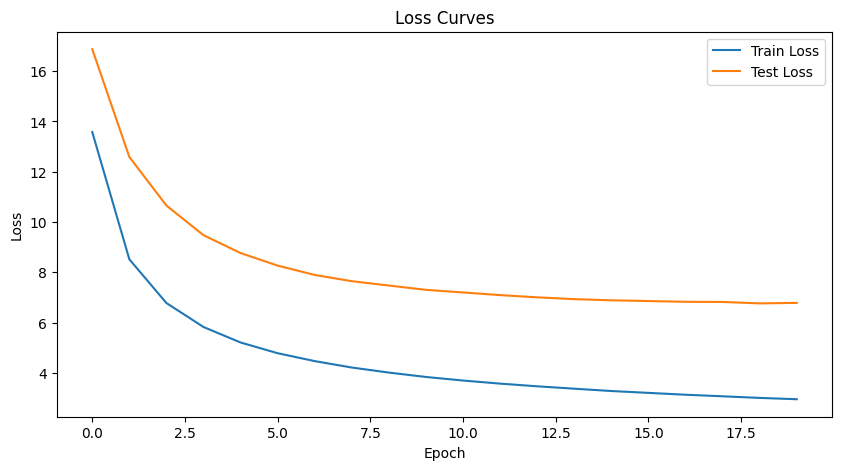

In [11]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
#print the avg losses per epoch
loss_hist = np.array(loss_hist)
test_loss_hist = np.array(test_loss_hist)

loss_hist_avg = np.mean(loss_hist.reshape(num_epochs, -1), axis=1)
test_loss_hist_avg = np.mean(test_loss_hist.reshape(num_epochs, -1), axis=1)

plt.plot(loss_hist_avg)
plt.plot(test_loss_hist_avg)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Test Set Accuracy
This function iterates over all minibatches to obtain a measure of accuracy over the full 10,000 samples in the test set.

In [12]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
#test_loader = DataLoader(train_set, batch_size=1, shuffle=True, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, collate_fn=tonic.collation.PadTensors(batch_first=False), drop_last=True)
test_batch = iter(test_loader)


with torch.no_grad():
  net.eval()
  for test_data, test_targets in test_batch:
    test_data = test_data.to(device)
    test_data = test_data[:,:,0,3:31,3:31].reshape(num_steps, batch_size, 28*28).type(torch.float)
    test_data[test_data >= 1] = 1
    test_targets = test_targets.to(device)

    test_spk_rec = []
    test_mem_rec = []

    # Test set forward pass
    for step in range(num_steps):
        test_spk, test_mem = net(test_data[step])
        test_spk_rec.append(test_spk)
        test_mem_rec.append(test_mem)

    test_spk_rec = torch.stack(test_spk_rec)
    test_mem_rec = torch.stack(test_mem_rec)

    _, predicted = test_spk_rec.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == test_targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 9512/9984
Test Set Accuracy: 95.27%


# Save the weights


In [13]:
torch.save(net.state_dict(), "trained_snn_n-mnist_weights_only.pt")

# Save the dataset

Save the dataset as a text file for importing into Vitis

In [14]:
#get all data from test_set as a single tensor
test_loader = DataLoader(test_set, batch_size=1, shuffle=True, collate_fn=tonic.collation.PadTensors(batch_first=False), drop_last=True)
test_data = []
test_targets = []
for data, targets in test_loader:
    test_data.append(data)
    test_targets.append(targets)
test_data = torch.cat(test_data, dim=0)
test_targets = torch.cat(test_targets, dim=0)
test_data = test_data
test_data = test_data[:,:,0,3:31,3:31].reshape(num_steps, -1, 28*28).type(torch.float)
test_data[test_data >= 1] = 1

In [15]:

with open('dataset/n-mnist_testset_data.txt', 'w') as f:
    for i in range(test_data.size(0)):
        for j in range(test_data.size(1)):
            for k in range(test_data.size(2)):
                f.write(str(int(test_data[i][j][k].item())))
                f.write('\n')


with open('dataset/n-mnist_testset_targets.txt', 'w') as f:
    for i in range(test_targets.size(0)):
        f.write(str(test_targets[i].item()))
        f.write('\n')

net.load_state_dict(torch.load("trained_snn_n-mnist_weights_only.pt"))

<All keys matched successfully>

# Save the weights as a C header file

In [16]:

with open('weights/n-mnist_weights.h', 'w') as f:
    f.write('#ifndef N_MNIST_WEIGHTS_H\n')
    f.write('#define N_MNIST_WEIGHTS_H\n')
    f.write(f'weight_t weights_0[{num_hidden}][784] = {{')
    for i in range(num_hidden):
        f.write('{')
        for j in range(784):
            f.write(str(net.state_dict()["0.weight"][i][j].item()))
            if j != 783:
                f.write(',')
        f.write('}\n')
        if i != num_hidden - 1:
            f.write(',')
    f.write('};')
    f.write(f'\nweight_t weights_1[{num_outputs}][{num_hidden}] = {{')
    for i in range(num_outputs):
        f.write('{')
        for j in range(num_hidden):
            f.write(str(net.state_dict()["2.weight"][i][j].item()))
            if j != num_hidden - 1:
                f.write(',')
        f.write('}\n')
        if i != num_outputs - 1:
            f.write(',')
    f.write('};')
    f.write(f'\n#endif // N_MNIST_WEIGHTS_H\n')

In [17]:
#print min max weights
print(f"Min weight 0: {net.state_dict()['0.weight'].min()}")
print(f"Max weight 0: {net.state_dict()['0.weight'].max()}")
print(f"Min weight 1: {net.state_dict()['2.weight'].min()}")
print(f"Max weight 1: {net.state_dict()['2.weight'].max()}")

Min weight 0: -1.403734564781189
Max weight 0: 1.1415107250213623
Min weight 1: -1.6141791343688965
Max weight 1: 1.3058664798736572
